# Forced Photometry Measurements at a Given Location

Brian Morsony <br>
Last modified 10/25/2022

## Introduction

This notebook is an example of using fake sources to do force photometry at a given location.  It works by loading an image from the butler, adding a fake source at the desired coordinates, doing source detection on the modified image, then doing photometry on the origional image (with the fake source)

This works, but is slow if you want to do a full 5-year lightcurve.  Ideally, it should be possible to do photometry only on the added source, not all the sources in the image, but I haven't figure that out yet.

This notebook is based largely on the "fake_source_injection_multicolor" notebook written by Jeff Carlin.  The fake source injection and image processing routines are borrowed from that code.




In [1]:
# First, import a bunch of python packages:

# Import python packages
import time
import os
import warnings
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import IFrame, display, Markdown
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
from astropy.visualization import ZScaleInterval
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, vstack
from astropy.time import Time


# Import tasks from the LSST Science Pipelines for reprocessing images
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.pipe.tasks.calibrate import CalibrateTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask

import lsst.sphgeom


# Import LSST Science Pipelines packages (see pipelines.lsst.io)
import lsst.daf.base as dafBase
from lsst.daf.butler import Butler
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom
import lsst.pipe.tasks.fakes as fakes

# Use lsst.afw.display with the matplotlib backend
afwDisplay.setDefaultBackend('matplotlib')





print('All packages loaded')

All packages loaded


## Define functions

In the next few cells, we define the function need to inject fake sources, process images, and a wrapper to do the force photometry at a given location, band, etc.

In [2]:
# Set up functions to add fakes stars to an image:


# make stars at a given position with a given intensity
# I am using this to make a fake source at the location I want to do photometry
def makeFakeStar(position, intensity, psf):
    psfImage = psf.computeImage(geom.Point2D(position.x, position.y)).getArray()
    psfImage *= intensity
    noise = np.random.normal(0, np.sqrt(abs(psfImage)))
    return psfImage + noise, noise





# This is used to add multiple fake stars.  I really just need to do one source.
def addFakeStars(ras, decs, mags, calexp_ref, butler):
    
    # Load the image with the given calexp_ref ID
    calexp_inp = butler.get('calexp', calexp_ref.dataId)
    
    # Make a copy of the image to add fake sources to
    calexp_withFakes = calexp_inp.clone()

    
    # Fetch objects from the exposure
    psf = calexp_withFakes.getPsf()
    image = calexp_withFakes.getMaskedImage().getImage()
    variance = calexp_withFakes.getMaskedImage().getVariance()
    wcs = calexp_withFakes.getWcs()
    photocalib = calexp_withFakes.getPhotoCalib()
       
    dt = calexp_withFakes.getInfo().getVisitInfo().getDate().toPython()
    mjd = Time(dt).mjd
    print(mjd)
    
    fluxes = []
    
    noise_scale = np.mean(image.getArray())    
    image_size = image.getArray().shape
    
    print('noise_scale = ',noise_scale)
    print('image_size = ',image_size)
    
    
    # Use the "photocalib" from the calexp to convert magnitudes to instrumental fluxes:
    for mag in mags:
        fluxes.append(photocalib.magnitudeToInstFlux(mag))

    # Get the corner coordinates of the image:
    y0 = image.getY0()
    x0 = image.getX0()
    ymax = y0 + calexp_withFakes.getDimensions()[1]
    xmax = x0 + calexp_withFakes.getDimensions()[0]

    
    # At each position create a star with the given intensity and add it
    # to the image.
    for ra, dec, intensity in zip(ras, decs, fluxes):
        # Use the WCS to convert RA, Dec to X, Y pixel coordinates:
        pos = wcs.skyToPixel(geom.SpherePoint(ra, dec, geom.degrees))
 
        # Call "makeFakeStar" to get the image of a PSF-like object with the desired flux:
        objArray, noiseArray = makeFakeStar(pos, intensity, psf)
        psfRad = int((objArray.shape[0]-1)/2.)

        # Check that the desired position is within the image:
        oky = (pos.y > psfRad) & (pos.y < ymax - psfRad)
        okx = (pos.x > psfRad) & (pos.x < xmax - psfRad)

        if okx & oky:
            yslice = slice(int(np.floor(pos.y - psfRad - y0)), int(np.floor(pos.y + psfRad + y0 + 1)))
            xslice = slice(int(np.floor(pos.x - psfRad - x0)), int(np.floor(pos.x + psfRad + x0 + 1)))

            print('Injecting source at x, y = ', pos.x, pos.y)
            print('xslice = ',xslice,x0)

            # NOTE: while image arrays are indexed with x, y, the extraction of the data into (numpy) arrays
            # means that the returned arrays follow numpy's y, x convention.
            # More on indexing: https://pipelines.lsst.io/modules/lsst.afw.image/indexing-conventions.html
            
            # To do full image source detection:
            image.getArray()[yslice, xslice] += objArray - noiseArray
            
        else:
            print('Skipped injecting source at x, y = ', pos.x, pos.y, ' because it is too close to (or off) the edge.')

    return calexp_inp, calexp_withFakes


print('Ready to add fake sources')


Ready to add fake sources


In [3]:
# Set up function to do photometry on image with fake sources included:

# Process the image with fake sources added and do photometry on all (real and fake) sources
def processFakes(calexp_inp, calexp_inp_new):
    
    # Create a basic schema to use with these tasks
    schema = afwTable.SourceTable.makeMinimalSchema()

    print('schema = ')
    print(schema)
    
    # Create a container which will be used to record metadata about algorithm execution
    algMetadata = dafBase.PropertyList()

    # Initialize CharacterizeImageTask and its configuration:
    config = CharacterizeImageTask.ConfigClass()
    config.psfIterations = 1
    charImageTask = CharacterizeImageTask(None, config=config)

    # Initialize SourceDetectionTask and its configuration:
    config = SourceDetectionTask.ConfigClass()
    config.thresholdValue = 10      # detection threshold in units of thresholdType
    config.thresholdType = "stdev"   # units for thresholdValue
    sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)
    sourceDeblendTask = SourceDeblendTask(schema=schema)

    # Initialize SingleFrameMeasurementTask and its configuration:
    config = SingleFrameMeasurementTask.ConfigClass()
    sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=config, algMetadata=algMetadata)

    #print('after config, schema = ')
    #print(schema)

    
    # Make an empty table that we'll put the results in:
    tab = afwTable.SourceTable.make(schema)
    
    # Image characterization

    # I'm not sure what this does or if it is necessary, but it seems to take a long time - Brian Morsony, 7/29/2022
    # result = charImageTask.run(calexp_inp)

    # Get the PSF and some image properties
    psf = calexp_inp.getPsf()
    sigma = psf.computeShape().getDeterminantRadius()
    pixelScale = calexp_inp.getWcs().getPixelScale().asArcseconds()

    # The factor of 2.355 converts from std to fwhm
    
    #sigma = 1./pixelScale/2.355
    print('psf fwhm = {:.2f} arcsec'.format(sigma*pixelScale*2.355))
    
    
    # Run source detection on the image with fake sources
    result = sourceDetectionTask.run(tab, calexp_inp_new)
    
    
    sources = result.sources

    del result

    sources = sources.copy(True)

    
    
    # Run source deblending on origional image
    sourceDeblendTask.run(calexp_inp, sources)

    
    sources = sources.copy(True)
    
    sources_test = sources.asAstropy()
    #print('sources_test')
    #print(sources_test)
    

    
    # Run source measurement on origional image
    sourceMeasurementTask.run(measCat=sources, exposure=calexp_inp)

    
    
    # The copy makes sure that the sources are sequential in memory
    sources = sources.copy(True)
    
    # For convenience, return an Astropy table:
    source_tab = sources.asAstropy()
    
    # Convert fluxes to magnitudes and add them to the table
    photocalib = calexp_inp.getPhotoCalib()
    psfmags = photocalib.instFluxToMagnitude(sources, 'base_PsfFlux')
    source_tab.add_columns([psfmags[:,0], psfmags[:,1]], names=['mag_psf', 'magerr_psf'])
    
    dt = calexp_inp.getInfo().getVisitInfo().getDate().toPython()
    mjd = Time(dt).mjd
    print(mjd)
    
    mjd_arr = psfmags.copy()
    mjd_arr[:] = mjd

    source_tab.add_columns([mjd_arr[:,1]], names=['mjd'])

    
    return(source_tab)



print('Ready to process images')


Ready to process images


In [4]:
# Now make a function to loop over several (or all) visits in a given band

# Do the photometry at a given location in one band
def photometry_at_coord_all_visits(racen,deccen,band,start_index=0,end_index=None,image_bool=False):

    # racen and deccen are the ra and dec of the location where you want to do photometry
    
    # To use the DP0.1 data, use this:

    # For DC2 gen3, these are the only optoins
    # repo = 's3://butler-us-central1-dp01'
    # collection = '2.2i/runs/DP0.1'
    #
    # butler = Butler(repo, collections=collection)



    # For DP0.2, we want the following configuration and collection:

    config = "dp02"
    collection = '2.2i/runs/DP0.2'

    butler = Butler(config=config, collections=collection)


    # I think I need this line for either collection, but not sure:
    registry = butler.registry

    
    # Higher levels make smaller triangles around the coordinates you want

    # pixelization = lsst.sphgeom.HtmPixelization(12)
    pixelization = lsst.sphgeom.HtmPixelization(14)


    htm_id = pixelization.index(
        lsst.sphgeom.UnitVector3d(
            lsst.sphgeom.LonLat.fromDegrees(racen, deccen)
        )
    )

    # Obtain and print the scale to provide a sense of the size of the sky pixelization being used
    scale = pixelization.triangle(htm_id).getBoundingCircle().getOpeningAngle().asDegrees()*3600
    print(f'HTM ID={htm_id} at level={pixelization.getLevel()} is a ~{scale:0.2}" triangle.')


    
    # Find all the visits for the given band:
    
    datasetRefs_u = registry.queryDatasets("calexp", htm20=htm_id, band=band)
     
    print("Found ", datasetRefs_u.count(), " ",band,"-band calexps at that position.")
    
    # I don't know how this is being sorted, but at least it seems to be in the same order each time.
    datasetRefs_u = sorted(datasetRefs_u)

    
    
    # For now, just take the first visit of each color.  Eventually want to make it do photometry for all visits:
    
    #for i, ref in enumerate(datasetRefs_u):
    #    if i==sort_index:
    #        uref = ref
    
    ref = datasetRefs_u[start_index:end_index]
    
    # Set up a face source at the given coordinates.
    
    fake_ras = np.array([racen])
    fake_decs = np.array([deccen])
    
    # Set the fake source to be 22nd magnitude.  This seems to be detectable but not overpowering.
    
    fake_umags = np.array([22.])

    
    # Go through and add the fake source to all images.

    for i, uref in enumerate(ref):
        
        print(' ')
        print('i = ',i)
    
        calexp_orig_u, calexp_new_u = addFakeStars(fake_ras, fake_decs, fake_umags, uref, butler)
    

        # Process all the fake images to do photometry.
        # Eventaully probably need to make this a loop over all viists.

        t1 = time.time()

        sources_withfakes_u = processFakes(calexp_orig_u,calexp_new_u)

        t2 = time.time()
        print('dt', t2 - t1)

        
    
        # Now match input sources to photometry sources

        # Coordinates of input fake stars
        sc_fakes = SkyCoord(ra=fake_ras*u.deg, dec=fake_decs*u.deg, frame='icrs')

        # Coordinates of objects in calexps with fakes added:
        sc_withfakes_u = SkyCoord(ra=sources_withfakes_u['coord_ra'], dec=sources_withfakes_u['coord_dec'], frame='icrs')

        
        
        # Plot an image of all sources adn fake source location:
    
        if image_bool==True:
            fig, ax = plt.subplots(1, 1)
            plt.plot(sc_withfakes_u.ra, sc_withfakes_u.dec, '.k', label='detected sources')
            plt.plot(sc_fakes.ra, sc_fakes.dec, 'sr', fillstyle='none', label='fake sources')
            ax.invert_xaxis()
            plt.legend()
            plt.xlabel('RA (deg)')
            plt.ylabel('Dec (deg)')
            plt.show()
        
        

        # Match them using the Astropy SkyCoord "match_to_catalog_sky" method:

        idx_u, sep_u, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_u)

        # Return the table, match sources, id of matched source, and separation of matched source
        # return sourcers_withfakes_u, sc_withfakes_u, idx_u, sep_u



        okmch_u = (sep_u.arcsec < 1.0)
        mch_mags_u = sources_withfakes_u[idx_u]['mag_psf']
        mch_magerrs_u = sources_withfakes_u[idx_u]['magerr_psf']
        # If the nearest match is >1" away, set its magnitudes to -99.9:
        mch_mags_u[~okmch_u] = -99.9
        mch_magerrs_u[~okmch_u] = -99.9
        mch_flux_u = sources_withfakes_u[idx_u]['base_PsfFlux_instFlux']
        mch_fluxerr_u = sources_withfakes_u[idx_u]['base_PsfFlux_instFluxErr']
        mch_flux_u[~okmch_u] = -99.9
        mch_fluxerr_u[~okmch_u] = -99.9
        mch_mjd_u = sources_withfakes_u[idx_u]['mjd']
        seps_u = sep_u.arcsec


        #print(fake_imags[okmch], sources_withfakes_i[idx_i[okmch]]['mag_psf'])



        # Make a table of fake sources and measured fluxes    


        print('Data to table = ',band,mch_flux_u[0], mch_fluxerr_u[0], mch_mags_u[0], mch_magerrs_u[0], seps_u[0])

        # one band table
        tab_one = Table([fake_ras, fake_decs, mch_mjd_u,
                         mch_flux_u, mch_fluxerr_u, mch_mags_u, mch_magerrs_u, seps_u], 
                         names=['ra', 'dec', 'mjd',
                                'flux', 'fluxerr', 'meas', 'err_meas', 'sep'],
                         units=[u.deg, u.deg, u.d,
                                u.Jy, u.Jy, u.mag, u.mag, u.arcsec])

        if i==0:
            tab_all = tab_one.copy()
        else:
            tab_all = vstack([tab_all,tab_one])
            
        #print(tab_all)
        
    
    #for col in tab_all.colnames[0:2]:
    #    tab_all[col].info.format = '%.9g'  # for consistent table output
    #for col in tab_all.colnames[2:]:
    #    tab_all[col].info.format = '%.8g'  # for consistent table output
    
        

    return sources_withfakes_u, tab_all



print('Ready to do photometry')


Ready to do photometry



## Photometry Examples

Everything is set up now.  In the next several cells, we do some examples of force photometry at the location of a supernova.  

For some visits, the source will be off the edge of the detector or too close to the edge, so a fake source will not be added.  In these cases, we don't get photometry on the source, so the returned flux and flux error is set to -99.9.

When the sourceis added, we get photometry at that location.  Becuase there usually isn't a real source there, we can get positive and negative values of the flux, but the flux error should always be positive.


HTM ID=2359497778 at level=14 is a ~1.7e+01" triangle.
Found  52   u -band calexps at that position.
 
i =  0
59851.30014821991
noise_scale =  1.8755872
image_size =  (4000, 4072)
Skipped injecting source at x, y =  4245.563499786534 148.92215477870968  because it is too close to (or off) the edge.
schema = 
Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)

psf fwhm = 0.89 arcsec


/tmp/ipykernel_12199/2532271563.py:45: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


59851.30014821991
dt 5.890807390213013


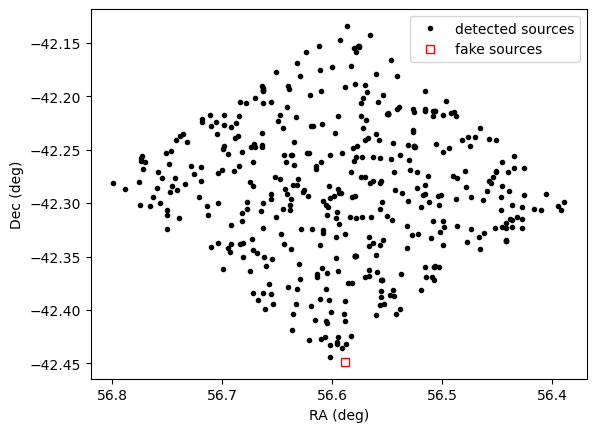

Data to table =  u -99.9 -99.9 -99.9 -99.9 40.07601948878525
Done


In [5]:
# Now do an example image:


np.random.seed(715)   # make it reproducable, not random

# for SN with DiaObjectID = 1326398051190837313
racen = 56.5885599
deccen = -42.4486176

# Pick the u band for less visits
band = 'u'

# Start with the first visit in the list.  The one happens to be outside the detector.

# This will plot an image of all detected sources, and a red box around the location where we want photometry.
# In this case, there is no source in the red box.

sources_withfakes_0, tab_0 = photometry_at_coord_all_visits(racen,deccen,band,
                                start_index=0,end_index=1,image_bool=True)

    
print('Done')



HTM ID=2359497778 at level=14 is a ~1.7e+01" triangle.
Found  52   u -band calexps at that position.
 
i =  0
59819.29373722222
noise_scale =  1.0413336
image_size =  (4000, 4072)
Injecting source at x, y =  1174.1851199230614 3287.2078154926985
xslice =  slice(1154, 1195, None) 0
schema = 
Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)

psf fwhm = 1.05 arcsec


/tmp/ipykernel_12199/2532271563.py:45: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


59819.29373722222
dt 5.809568166732788


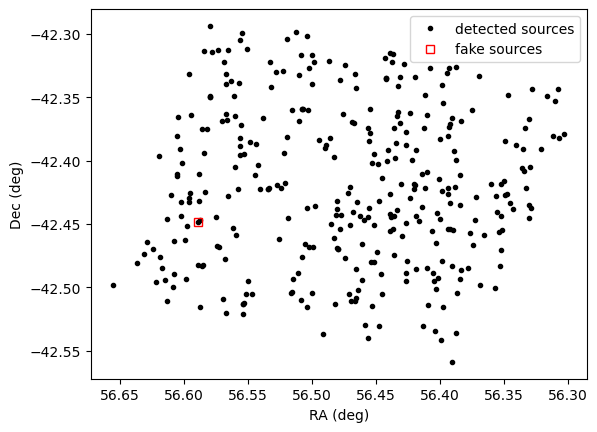

Data to table =  u -34.661063016748216 95.40797465376022 nan 2.9885953928377114 0.05571602180273029
Done


In [6]:
# Let's pick a different visit, where the coordiates are on the detector.

# In this case, there is a source in the red box, and photometry is done on it.


np.random.seed(715)   # make it reproducable, not random

sources_withfakes_2, tab_2 = photometry_at_coord_all_visits(racen,deccen,band,
                                start_index=2,end_index=3,image_bool=True)
    
print('Done')



In [7]:
# Use the data in the returned table to print some info about the photometry.


print('u-band flux =',tab_2[0]['flux'],'+/-',tab_2[0]['fluxerr'],'at mjd =',tab_2[0]['mjd'])

print(' ')

# Now print the actual table (with 1 entry)

print(tab_2[0])



u-band flux = -34.661063016748216 +/- 95.40797465376022 at mjd = 59819.29373722222
 
    ra         dec            mjd                flux             fluxerr      meas      err_meas              sep        
   deg         deg             d                  Jy                 Jy        mag         mag                arcsec      
---------- ----------- ----------------- ------------------- ----------------- ---- ------------------ -------------------
56.5885599 -42.4486176 59819.29373722222 -34.661063016748216 95.40797465376022  nan 2.9885953928377114 0.05571602180273029


In [8]:
# Now let's load several images in the same band.  
# To load 10 images takes about 1.5 minutes

# We'll be able to see detections, upper limits, and sources off the detector.

np.random.seed(715)   # make it reproducable, not random

sources_withfakes_u, tab_u = photometry_at_coord_all_visits(racen,deccen,band,start_index=25,end_index=35)

print('Done')



HTM ID=2359497778 at level=14 is a ~1.7e+01" triangle.
Found  52   u -band calexps at that position.
 
i =  0
60731.04764222221
noise_scale =  0.97060215
image_size =  (4000, 4072)
Injecting source at x, y =  2969.8669260235974 2293.7605985931536
xslice =  slice(2949, 2990, None) 0
schema = 
Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)

psf fwhm = 0.82 arcsec


/tmp/ipykernel_12199/2532271563.py:45: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


60731.04764222221
dt 5.701986312866211
Data to table =  u -97.72790550288926 72.32142105499395 nan 0.8034757802531254 0.23041125168857002
 
i =  1
60731.048987222224
noise_scale =  1.2524506
image_size =  (4000, 4072)
Injecting source at x, y =  2262.3910859461052 2323.759161006365
xslice =  slice(2242, 2283, None) 0
schema = 
Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)

psf fwhm = 0.84 arcsec


/tmp/ipykernel_12199/2532271563.py:45: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


60731.048987222224
dt 5.7525787353515625
Data to table =  u 41.083304852076004 76.48574590609459 26.44637451415818 2.0213404375738935 0.2598857770461346
 
i =  2
60673.10369122454
noise_scale =  0.93276185
image_size =  (4000, 4072)
Injecting source at x, y =  908.1471775631339 1619.5826323563656
xslice =  slice(888, 929, None) 0
schema = 
Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)

psf fwhm = 1.10 arcsec


/tmp/ipykernel_12199/2532271563.py:45: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


60673.10369122454
dt 5.9314446449279785
Data to table =  u 456.73379640317245 103.1693870883647 23.813700386504138 0.2452521983368826 0.3128759534348407
 
i =  3
60674.10650522106
noise_scale =  0.9713574
image_size =  (4000, 4072)
Skipped injecting source at x, y =  4274.703340159939 1955.9844340172892  because it is too close to (or off) the edge.
schema = 
Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)

psf fwhm = 1.05 arcsec


/tmp/ipykernel_12199/2532271563.py:45: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


60674.10650522106
dt 5.782605409622192
Data to table =  u -99.9 -99.9 -99.9 -99.9 77.55381090293359
 
i =  4
60674.10650522106
noise_scale =  1.1925007
image_size =  (4000, 4072)
Injecting source at x, y =  24.564009703954525 1951.916647046064
xslice =  slice(4, 45, None) 0
schema = 
Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)

psf fwhm = 1.05 arcsec


/tmp/ipykernel_12199/2532271563.py:45: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


60674.10650522106
dt 5.908107280731201
Data to table =  u 395.04623436717804 99.52279538437035 23.97219013289456 0.2735264700074917 0.0895752765418362
 
i =  5
60911.29311722222
noise_scale =  1.2279929
image_size =  (4000, 4072)
Skipped injecting source at x, y =  3538.680485327306 4188.495363324396  because it is too close to (or off) the edge.
schema = 
Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)

psf fwhm = 1.09 arcsec


/tmp/ipykernel_12199/2532271563.py:45: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


60911.29311722222
dt 5.518148422241211
Data to table =  u -99.9 -99.9 -99.9 -99.9 77.49960188429155
 
i =  6
60911.29311722222
noise_scale =  1.0620489
image_size =  (4000, 4072)
Skipped injecting source at x, y =  3537.9189330398553 -37.97612702103652  because it is too close to (or off) the edge.
schema = 
Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)

psf fwhm = 1.09 arcsec


/tmp/ipykernel_12199/2532271563.py:45: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


60911.29311722222
dt 5.77482795715332
Data to table =  u -99.9 -99.9 -99.9 -99.9 40.030895170900145
 
i =  7
60970.166018219905
noise_scale =  1.0675298
image_size =  (4000, 4072)
Injecting source at x, y =  1212.112171167802 3586.0211974897
xslice =  slice(1192, 1233, None) 0
schema = 
Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)



/tmp/ipykernel_12199/2532271563.py:45: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


psf fwhm = 1.01 arcsec


60970.166018219905
dt 5.972201108932495
Data to table =  u -20.088488896708807 90.78994517342858 nan 4.906985854129558 0.02284125134720498
 
i =  8
60995.06411522107
noise_scale =  0.9604461
image_size =  (4000, 4072)
Skipped injecting source at x, y =  4053.889855656078 2464.6678797232744  because it is too close to (or off) the edge.
schema = 
Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)

psf fwhm = 1.02 arcsec


/tmp/ipykernel_12199/2532271563.py:45: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


60995.06411522107
dt 5.84700608253479
Data to table =  u -99.9 -99.9 -99.9 -99.9 5.638687374366442
 
i =  9
60970.166467222225
noise_scale =  1.1752998
image_size =  (4000, 4072)
Injecting source at x, y =  330.67759906530637 2303.502579896042
xslice =  slice(310, 351, None) 0
schema = 
Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)

psf fwhm = 1.03 arcsec


/tmp/ipykernel_12199/2532271563.py:45: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


60970.166467222225
dt 5.613714933395386
Data to table =  u -123.34988107482111 89.78641284281821 nan 0.7903077713355965 0.330011885568567
Done


In [9]:
# Print out the table for all the photometry

# print('u-band flux =',tab_u[0]['flux'],'+/-',tab_u[0]['fluxerr'],'at mjd =',tab_u[0]['mjd'])

# sources_withfakes_u

tab_u

ra,dec,mjd,flux,fluxerr,meas,err_meas,sep
deg,deg,d,Jy,Jy,mag,mag,arcsec
float64,float64,float64,float64,float64,float64,float64,float64
56.5885599,-42.4486176,60731.04764222221,-97.72790550288926,72.32142105499395,nan,0.8034757802531254,0.23041125168857002
56.5885599,-42.4486176,60731.048987222224,41.083304852076004,76.48574590609459,26.44637451415818,2.0213404375738935,0.2598857770461346
56.5885599,-42.4486176,60673.10369122454,456.73379640317245,103.1693870883647,23.813700386504138,0.2452521983368826,0.3128759534348407
56.5885599,-42.4486176,60674.10650522106,-99.9,-99.9,-99.9,-99.9,77.55381090293359
56.5885599,-42.4486176,60674.10650522106,395.04623436717804,99.52279538437035,23.97219013289456,0.2735264700074917,0.0895752765418362
56.5885599,-42.4486176,60911.29311722222,-99.9,-99.9,-99.9,-99.9,77.49960188429155
56.5885599,-42.4486176,60911.29311722222,-99.9,-99.9,-99.9,-99.9,40.030895170900145
56.5885599,-42.4486176,60970.166018219905,-20.088488896708807,90.78994517342858,nan,4.906985854129558,0.02284125134720498


4 bad sources
4 upper limits
2 detections


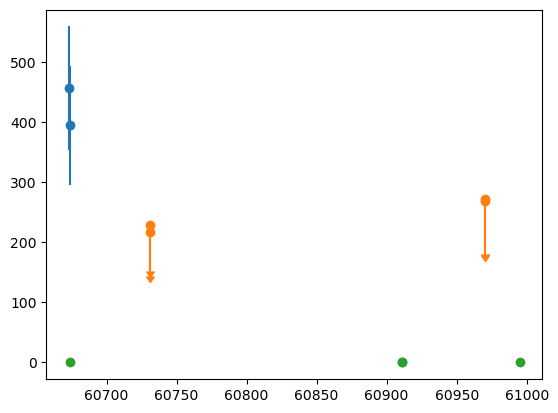

In [10]:
# Now let take a closer look at the data, and make a plot of it.

# First, get the times, fluxes, and flux errors

time_u = np.array(tab_u['mjd'][:])
flux_u = np.array(tab_u['flux'][:])
fluxerr_u = np.array(tab_u['fluxerr'][:])


# We can use the flux information to split into 3 arrays: 
# bad values (off detector), detections, and non-detections

# The sources with flux_u and fluxerr_u = -99.9 are out of the field of view, 
# so there's nothing to measure.

# This will identify the "good" sources, that are on the detector

good_source_arr = np.ones(time_u.size,dtype=bool)

for i in np.arange(time_u.size):
    if (fluxerr_u[i] < 0):
        good_source_arr[i] = False

        



# Now go through all the sources (good and bad), and flag the ones that are upper limits.

upper_limit_arr = np.ones(time_u.size,dtype=bool)  # True if upper limit, false otherwise
flux_corr_u = np.copy(fluxerr_u)*3.   # flux set to 3 times sigma if it is an upper limit

for i in np.arange(time_u.size):
    if (flux_u[i] > fluxerr_u[i]*3.):
        upper_limit_arr[i] = False
        flux_corr_u[i] = flux_u[i]


# Now identify our 3 types of sources: bad, upper limit, and detected
# This will give you the indicies of each type in the origional arrays

bad_sources = np.argwhere(good_source_arr == False)[:,0]
upper_limit_sources = np.argwhere((upper_limit_arr == True) & (good_source_arr == True))[:,0]
detected_sources = np.argwhere((upper_limit_arr == False) & (good_source_arr == True))[:,0]


# Now make an array for the time, flux, and flux error for each type of source.
# For upper limits, the flux will be 3x the flux error, e.g. the 3-sigma upper limit.


bad_time_u = time_u[bad_sources]
bad_flux_u = flux_u[bad_sources]
bad_fluxerr_u = fluxerr_u[bad_sources]

upper_limit_time_u = time_u[upper_limit_sources]
upper_limit_flux_u = flux_corr_u[upper_limit_sources]
upper_limit_fluxerr_u = fluxerr_u[upper_limit_sources]

detected_time_u = time_u[detected_sources]
detected_flux_u = flux_corr_u[detected_sources]
detected_fluxerr_u = fluxerr_u[detected_sources]


# Print out how many of each type there are

print(bad_time_u.size,'bad sources')
print(upper_limit_time_u.size,'upper limits')
print(detected_time_u.size,'detections')


# This will make a plot of the source for all visits.
# Blue will be detetions with error bars
# Orange will be upper limits, with arrows
# Green will be bad sources, plotted as zero flux

plt.errorbar(detected_time_u,detected_flux_u,yerr=detected_fluxerr_u,marker='o',linestyle='none')
plt.errorbar(upper_limit_time_u,upper_limit_flux_u,yerr=upper_limit_fluxerr_u,uplims=True,marker='o',linestyle='none')
plt.plot(bad_time_u,np.zeros(bad_time_u.size),'o')
#plt.errorbar(upper_limit_time_u,upper_limit_flux_u,yerr=upper_limit_fluxerr_u,marker='o',linestyle='none')
plt.show()

    
    

## Full R-band Light Curve

The following box will do photometry for our location for all r-band visits.  

This takes about 30 minutes to run.

The long runtime is partially because there are more visits than u-band (132 vs. 52 for this example) and there are more sources per image than in u-band, so each image takes longer to process.



In [ ]:
# This box will load all the observations in r-band.  
# This takes about 30 minutes to run.


sources_withfakes_r, tab_r = photometry_at_coord_all_visits(racen,deccen,'r',start_index=0)



In [ ]:
# Now let take a closer look at the r-band data, and make a plot of it.

# First, get the times, fluxes, and flux errors

time_u = np.array(tab_r['mjd'][:])
flux_u = np.array(tab_r['flux'][:])
fluxerr_u = np.array(tab_r['fluxerr'][:])


# We can use the flux information to split into 3 arrays: 
# bad values (off detector), detections, and non-detections

# The sources with flux_u and fluxerr_u = -99.9 are out of the field of view, 
# so there's nothing to measure.

# This will identify the "good" sources, that are on the detector

good_source_arr = np.ones(time_u.size,dtype=bool)

for i in np.arange(time_u.size):
    if (fluxerr_u[i] < 0):
        good_source_arr[i] = False

        



# Now go through all the sources (good and bad), and flag the ones that are upper limits.

upper_limit_arr = np.ones(time_u.size,dtype=bool)  # True if upper limit, false otherwise
flux_corr_u = np.copy(fluxerr_u)*3.   # flux set to 3 times sigma if it is an upper limit

for i in np.arange(time_u.size):
    if (flux_u[i] > fluxerr_u[i]*3.):
        upper_limit_arr[i] = False
        flux_corr_u[i] = flux_u[i]


# Now identify our 3 types of sources: bad, upper limit, and detected
# This will give you the indicies of each type in the origional arrays

bad_sources = np.argwhere(good_source_arr == False)[:,0]
upper_limit_sources = np.argwhere((upper_limit_arr == True) & (good_source_arr == True))[:,0]
detected_sources = np.argwhere((upper_limit_arr == False) & (good_source_arr == True))[:,0]


# Now make an array for the time, flux, and flux error for each type of source.
# For upper limits, the flux will be 3x the flux error, e.g. the 3-sigma upper limit.


bad_time_u = time_u[bad_sources]
bad_flux_u = flux_u[bad_sources]
bad_fluxerr_u = fluxerr_u[bad_sources]

upper_limit_time_u = time_u[upper_limit_sources]
upper_limit_flux_u = flux_corr_u[upper_limit_sources]
upper_limit_fluxerr_u = fluxerr_u[upper_limit_sources]

detected_time_u = time_u[detected_sources]
detected_flux_u = flux_corr_u[detected_sources]
detected_fluxerr_u = fluxerr_u[detected_sources]


# Print out how many of each type there are

print(bad_time_u.size,'bad sources')
print(upper_limit_time_u.size,'upper limits')
print(detected_time_u.size,'detections')


# This will make a plot of the source for all visits.
# Blue will be detetions with error bars
# Orange will be upper limits, with arrows
# Green will be bad sources, plotted as zero flux

# For this data, I'm plotting it on a log scale

plt.errorbar(upper_limit_time_u,upper_limit_flux_u,yerr=upper_limit_fluxerr_u,uplims=True,marker='o',linestyle='none',color='tab:orange')
plt.errorbar(detected_time_u,detected_flux_u,yerr=detected_fluxerr_u,marker='o',linestyle='none',color='tab:blue')
plt.plot(bad_time_u,np.zeros(bad_time_u.size)+100,'o',color='tab:green')
#plt.errorbar(upper_limit_time_u,upper_limit_flux_u,yerr=upper_limit_fluxerr_u,marker='o',linestyle='none')
plt.yscale('log')
plt.show()

